Team 3: Zuzanna Szafranowska, Claudia Baca, Quim Comas

In [1]:
import cv2
import numpy as np
#inPython3.x:
import pickle as cPickle
#in Python2.x:
#import cPickle
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier

Let us first read the train and test files

In [2]:
train_images_filenames = cPickle.load(open('train_images_filenames.dat','rb'))
test_images_filenames = cPickle.load(open('test_images_filenames.dat','rb'))
train_labels = cPickle.load(open('train_labels.dat','rb'))
test_labels = cPickle.load(open('test_labels.dat','rb'))

We create a SIFT object detector and descriptor

In [3]:
SIFTdetector = cv2.xfeatures2d.SIFT_create(nfeatures=300)
SURFdetector = cv2.xfeatures2d.SURF_create(300)
ORBdetector = cv2.ORB_create()

We choose the type of local feature detector that we want to use. 

- 1 ==> SIFT
- 2 ==> SURF
- 3 ==> ORB
- 4 ==> Dense SIFT


In [57]:
x=2
#x = input("Enter a number to choose the local feature detector: ")

We compute the SIFT descriptors for all the train images and subsequently build a numpy array with all the descriptors stacked together

In [58]:
Train_descriptors = []
Train_label_per_descriptor = []

for filename,labels in zip(train_images_filenames,train_labels):
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    if(x==1):
        kpt,des=SIFTdetector.detectAndCompute(gray,None)
    if(x==2):
        kpt,des=SURFdetector.detectAndCompute(gray,None)
    if(x==3):
        kpt,des=ORBdetector.detectAndCompute(gray,None)
    if(x==4):
        step_size = 5
        kpt = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size) 
                                            for x in range(0, gray.shape[1], step_size)]
        kpt,des=SIFTdetector.compute(gray,kpt)
    if(x==5):
        step_size = 5
        kpt = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size) 
                                            for x in range(0, gray.shape[1], step_size)]
        kpt,des=SURFdetector.compute(gray,kpt)
        
    Train_descriptors.append(des)
    Train_label_per_descriptor.append(labels)

D=np.vstack(Train_descriptors)

Dense SIFT has been removed from the opencv-contrib package in version 3. Therefore, we fill in the keypoint array ourselves by making a grid a keypoints at a given density determined by the step_size parameter. Then, we calculate a descriptor at each keypoint by calling SIFTdetector.compute.


We now compute a k-means clustering on the descriptor space

In [104]:
k = 256
codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
codebook.fit(D)

MiniBatchKMeans(batch_size=5120, compute_labels=False, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10,
        n_clusters=256, n_init=3, random_state=42,
        reassignment_ratio=0.0001, tol=0.0, verbose=False)

And, for each train image, we project each keypoint descriptor to its closest visual word. We represent each of the images with the frequency of each visual word.

In [105]:
visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
for i in range(len(Train_descriptors)): 
    words=codebook.predict(Train_descriptors[i])
    visual_words[i,:]=np.bincount(words,minlength=k)

To see the effect of K value in KNN classifier we perform a cross validation with our training set to estimate the optimal K value. Also we represent the evolution of the accuracy for each k value to see the influence of the k value:   

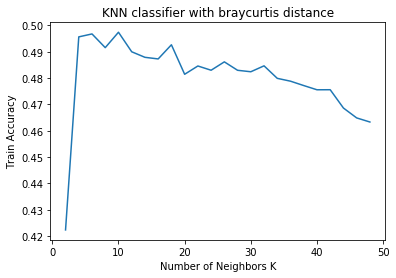

The optimal k value is 10


In [149]:
neighbors = list(filter(lambda x: x % 2 == 0, list(range(1,50))))
cv_scores = []

for kk in neighbors:
    knn = KNeighborsClassifier(n_neighbors=kk,n_jobs=-1,metric='euclidean')
    scores = cross_val_score(knn, visual_words, train_labels, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

optimal_k = neighbors[cv_scores.index(max(cv_scores))]

plt.title('KNN classifier with braycurtis distance')
plt.plot(neighbors, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Train Accuracy')
plt.show()
#python2.x
print("The optimal k value is %d" % optimal_k)
#python3.x
# print("The optimal k value is %d" % optimal_k)

We build a k-nn classifier and train it with the train descriptors

In [150]:
knn = KNeighborsClassifier(n_neighbors=optimal_k,n_jobs=-1,metric='euclidean')
knn.fit(visual_words, train_labels) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=-1, n_neighbors=10, p=2,
           weights='uniform')

We end up computing the test descriptors and compute the accuracy of the model

In [151]:
visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    if(x==1):
        kpt,des=SIFTdetector.detectAndCompute(gray,None)
    if(x==2):
        kpt,des=SURFdetector.detectAndCompute(gray,None)
    if(x==3):
        kpt,des=ORBdetector.detectAndCompute(gray,None)
    if(x==4):
        kpt = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size) 
                                            for x in range(0, gray.shape[1], step_size)]        
        kpt,des=SIFTdetector.compute(gray,kpt)
    if(x==5):
        step_size = 5
        kpt = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size) 
                                            for x in range(0, gray.shape[1], step_size)]
        kpt,des=SURFdetector.compute(gray,kpt)
        
    words=codebook.predict(des)
    visual_words_test[i,:]=np.bincount(words,minlength=k)

In [152]:
accuracy = 100*knn.score(visual_words_test, test_labels)
print(accuracy)

50.55762081784386


Accuracy's results are:

SIFT:

| Distance | Kbatch=128,Initial parameters | Kbatch=128,Optimal K |K=64,Initial parameters |
| --- | --- | --- | --- |
| Euclidean |  53.5315 | 55.8859 | 54.3990 |
| Chebyshev |  43.2465 | 44.6096 | 46.3444 |
| Manhattan |  50.1858 | 52.4163 | 53.4076 |
|  Hamming  |  35.1920 | 37.5464 | 38.16604|
| Canberra  |  50.1858 | 51.6728 | 49.0706 |
|Braycurtis |  57.1250 | 57.6208 | 54.7707 |

| Distance | Kbatch=64,Optimal K| Kbatch=256,Initial parameters | KBatch=256,Optimal K| 
| --- | --- | --- | --- |
| Euclidean | 54.0272 | 49.3184 | 49.5662 | 
| Chebyshev | 47.4597 | 42.1313 | 42.9987 |
| Manhattan | 53.7794 | 35.3159 | 35.4399 |
|  Hamming  | 42.5030 | 21.6852 | 23.1722 |
| Canberra  | 49.3184 | 47.5836 | 48.5749 | 
|Braycurtis | 55.0185 | 60.5947 | 61.2143 |

SURF:

| Distance | Kbatch=128,Initial parameters | Kbatch=128,Optimal K |K=64,Initial parameters |
| --- | --- | --- | --- |
| Euclidean |  54.7707 | 57.0012 | 58.8599 |
| Chebyshev |  46.8401 | 49.5662 | 52.1685 |
| Manhattan |  53.5315 | 53.5315 | 57.8686 |
|  Hamming  |  35.9355 | 37.1747 | 38.7856 |
| Canberra  |  55.7620 | 56.2577 | 56.7534 |
|Braycurtis |  62.5774 | 63.8166 | 61.8339 |

| Distance | Kbatch=64,Optimal K| Kbatch=256,Initial parameters | KBatch=256,Optimal K| 
| --- | --- | --- | --- |
| Euclidean | 58.6121 | 50.5576 | 50.5576 | 
| Chebyshev | 52.6641 | 47.4597 | 46.2205 |
| Manhattan | 59.1078 | 42.9987 | 43.2465 |
|  Hamming  | 40.6443 | 29.8636 | 31.1028 |
| Canberra  | 56.5055 | 52.4163 | 52.4163 |
|Braycurtis | 61.5861 | 63.5687 | 62.3296 |

ORB:

| Distance | Kbatch=128,Initial parameters | Kbatch=128,Optimal K |K=64,Initial parameters |
| --- | --- | --- | --- |
| Euclidean |  32.8376 | 36.4312 | |
| Chebyshev |  25.7744 | 27.7571 | |
| Manhattan |  33.2094 | 38.5377 | |
|  Hamming  |  26.0223 | 29.1201 | |
| Canberra  |  27.8810 | 30.6071 | |
|Braycurtis |  32.4659 | 32.4659 | |

| Distance | Kbatch=64,Optimal K| Kbatch=256,Initial parameters | KBatch=256,Optimal K| 
| --- | --- | --- | --- |
| Euclidean |   |  |  | 
| Chebyshev |   |  |  |
| Manhattan |   |  |  |
|  Hamming  |   |  |  |
| Canberra  |   |  |  |
|Braycurtis |   |  |  |

Dense SURF:

| Distance | Kbatch=128,Initial parameters | Kbatch=128,Optimal K |K=64,Initial parameters |
| --- | --- | --- | --- |
| Euclidean |  62.0817 | 63.9405 |61.8339|
| Chebyshev |  54.0272 | 54.1511 |57.8686|
| Manhattan |  64.9318 | 64.9318 |62.4535|
|  Hamming  |  42.0074 | 49.8141 |39.9008|
| Canberra  |  63.4448 | 63.9405 |63.8166|
|Braycurtis |  64.9318 | 65.1796 |62.8252|

| Distance | Kbatch=64,Optimal K| Kbatch=256,Initial parameters | KBatch=256,Optimal K| 
| --- | --- | --- | --- |
| Euclidean | 61.8339 | 64.6840 | 64.1883 | 
| Chebyshev | 57.8686 | 55.8859 | 52.5402 |
| Manhattan | 63.9405 | 67.4101 | 66.2949 |
|  Hamming  | 44.1140 | 50.8054 | 53.5315 |
| Canberra  | 64.1883 | 62.2057 | 63.4448 |
|Braycurtis | 63.5687 | 67.1623 | 66.4188 |



Dense SIFT:

| Distance | Kbatch=128,Initial parameters | Kbatch=128,Optimal K |K=64,Initial parameters |
| --- | --- | --- | --- |
| Euclidean |  70.1363 | 72.7385 | |
| Chebyshev |  58.7360 | 58.8599 | | 
| Manhattan |  76.7038 | 78.3147 | | 
|  Hamming  |  36.3073 | 38.6617 | |
| Canberra  |  74.2255 | 75.4646 | |
|Braycurtis |  76.7038 | 78.3147 | |

| Distance | Kbatch=64,Optimal K| Kbatch=256,Initial parameters | KBatch=256,Optimal K| 
| --- | --- | --- | --- |
| Euclidean |   |  |  |
| Chebyshev |   |  |  |
| Manhattan |   |  |  |
|  Hamming  |   |  |  |
| Canberra  |   |  |  |
|Braycurtis |   |  |  |












